In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap
from stardist.models import StarDist3D

np.random.seed(6)
lbl_cmap = random_label_cmap()

# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
We now load images from the sub-folder `test` that have not been used during training.

In [46]:
X = sorted(glob('data/test/images/*.tif'))
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

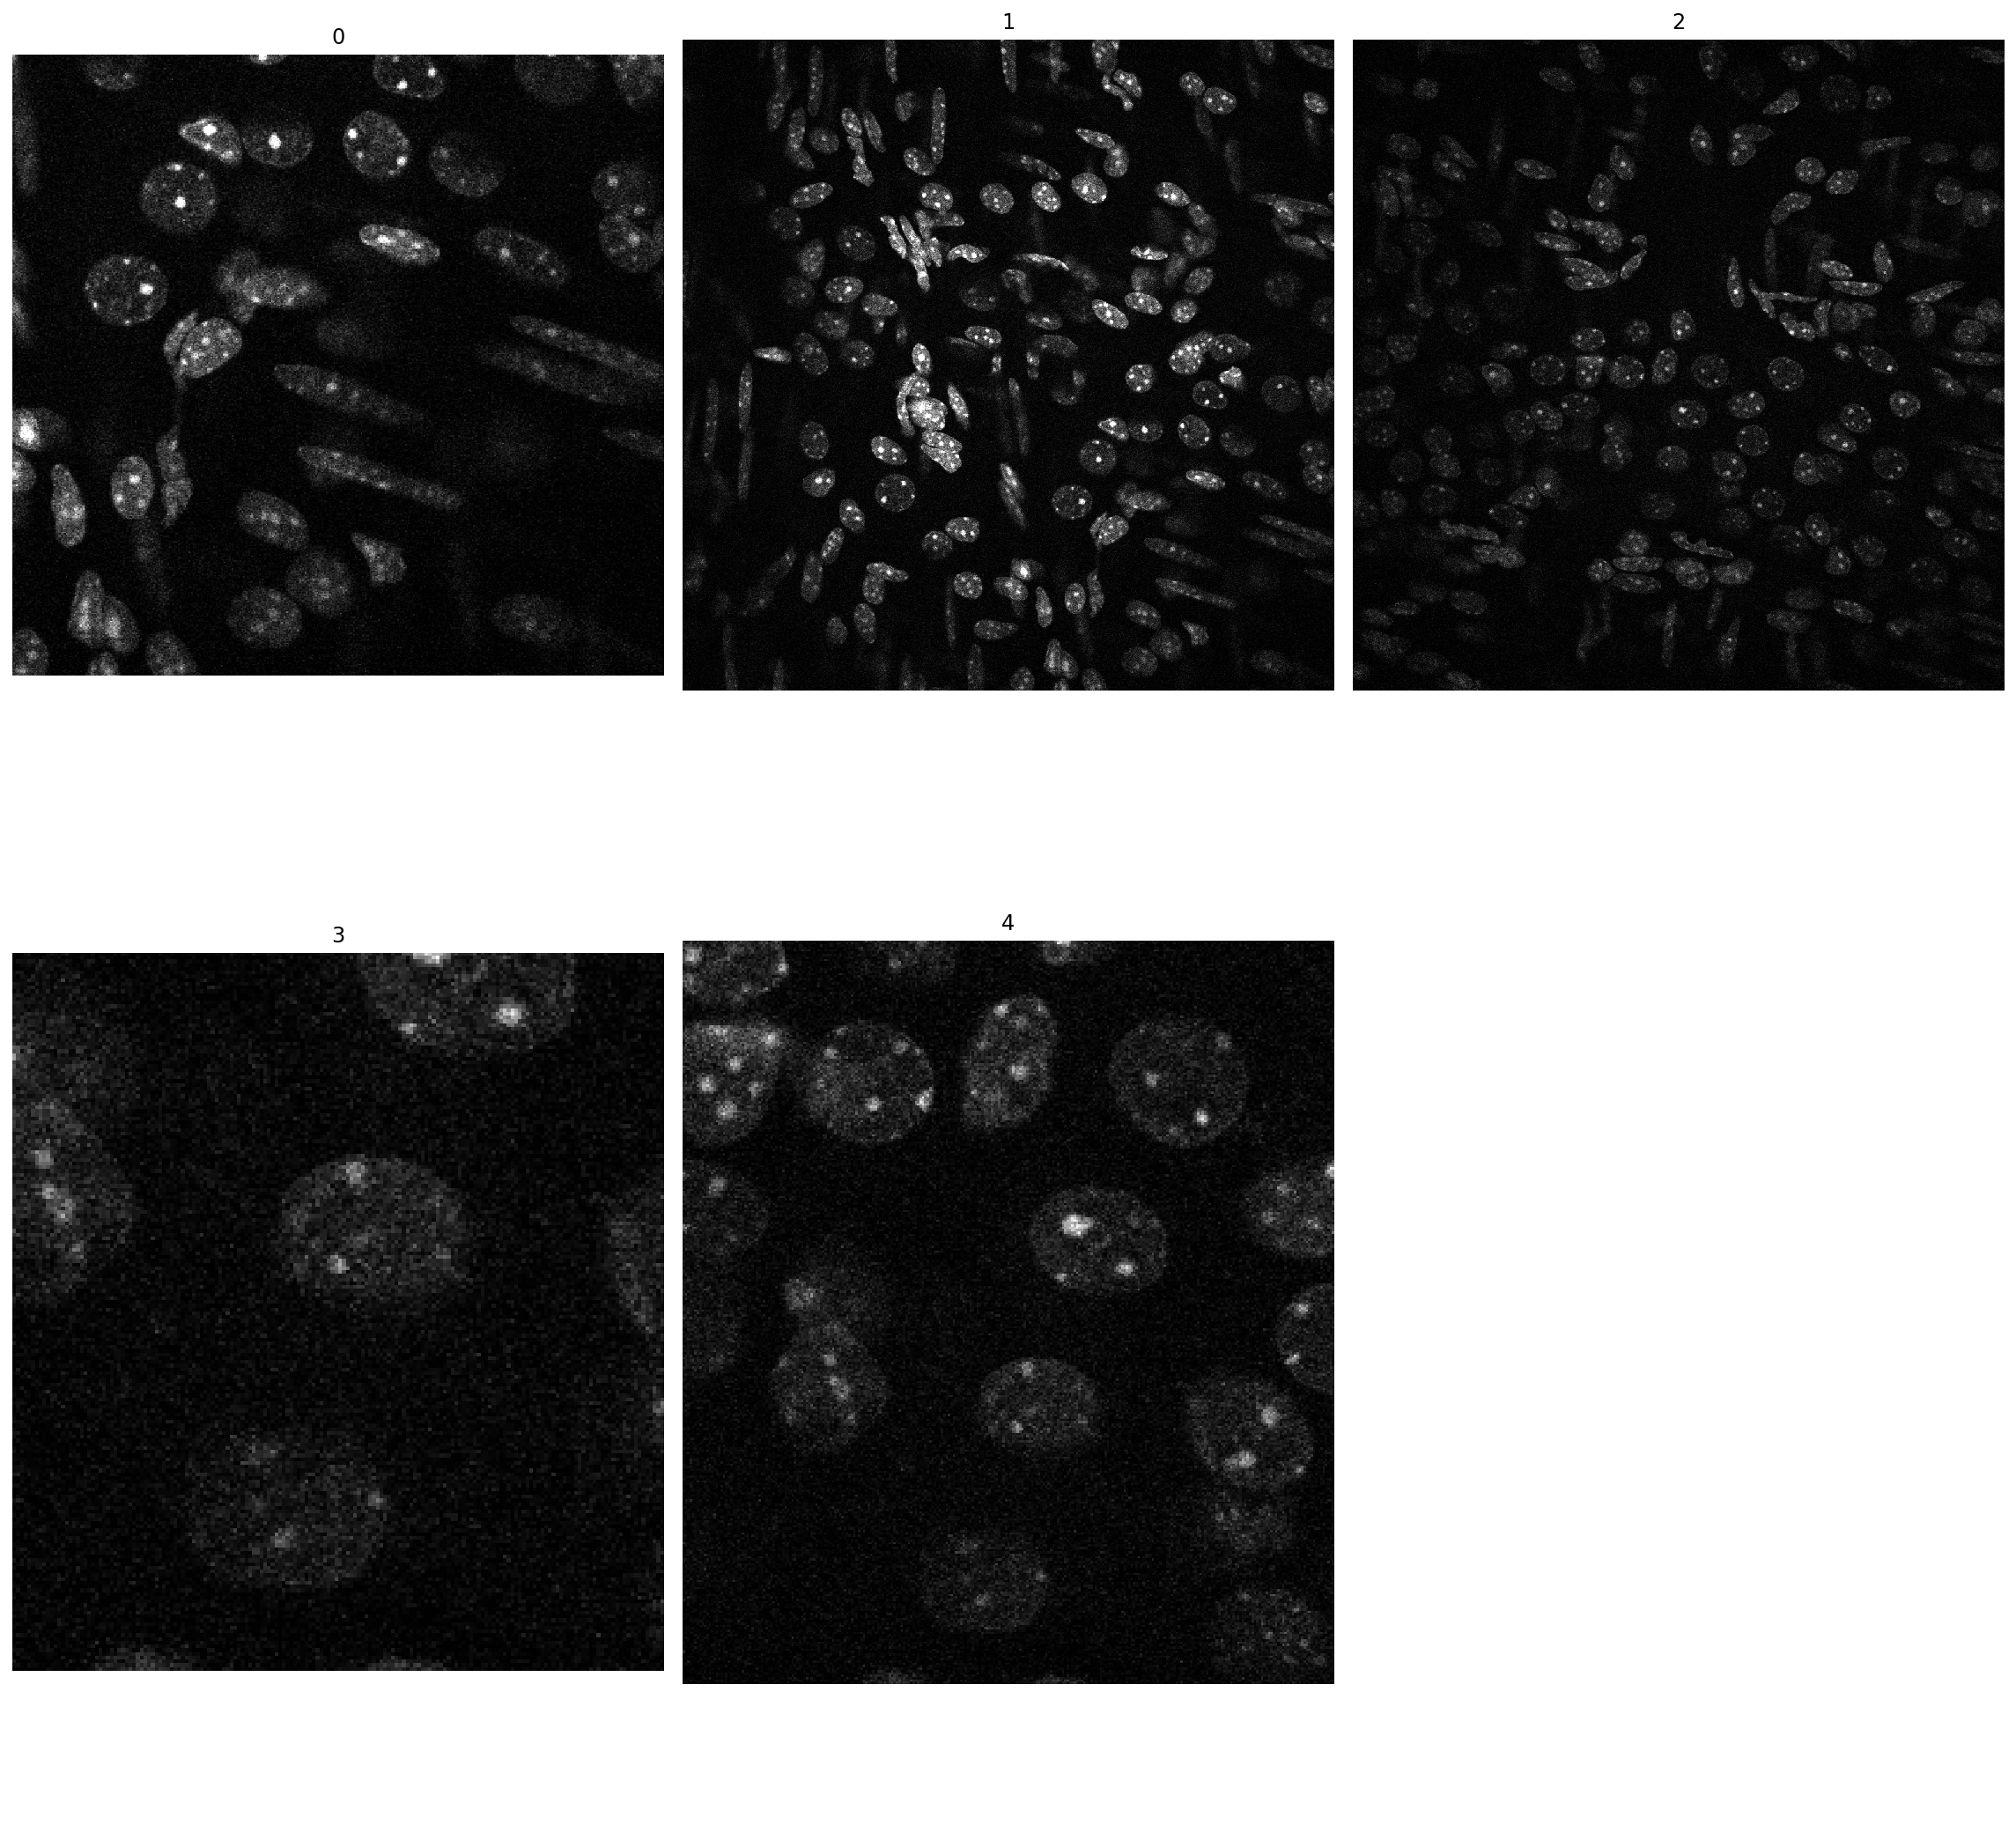

In [47]:
# show all test images
if True:
    fig, ax = plt.subplots(2,3, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x[x.shape[0]//2],cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load trained model

If you trained your own StarDist model (and optimized its thresholds) via notebook [2_training.ipynb](2_training.ipynb), then please set `demo_model = False` below.

In [19]:

model = StarDist3D(None, name='stardist3D96rays_p100', basedir='models')


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.556336, nms_thresh=0.3.


In [43]:
help(model.predict_instances_big)
help(model.predict_instances)

Help on method predict_instances_big in module stardist.models.base:

predict_instances_big(img, axes, block_size, min_overlap, context=None, labels_out=None, labels_out_dtype=<class 'numpy.int32'>, show_progress=True, **kwargs) method of stardist.models.model3d.StarDist3D instance
    Predict instance segmentation from very large input images.
    
    Intended to be used when `predict_instances` cannot be used due to memory limitations.
    This function will break the input image into blocks and process them individually
    via `predict_instances` and assemble all the partial results. If used as intended, the result
    should be the same as if `predict_instances` was used directly on the whole image.
    
    **Important**: The crucial assumption is that all predicted object instances are smaller than
                   the provided `min_overlap`. Also, it must hold that: min_overlap + 2*context < block_size.
    
    Example
    -------
    >>> img.shape
    (20000, 20000)
    >>

## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [32]:
#img = normalize(X[0], 1,99.8, axis=axis_norm)


In [34]:
#labels, details = model.predict_instances(img,n_tiles=(10,10,2))

 10%|████████                                                                         | 20/200 [00:18<02:50,  1.06it/s]


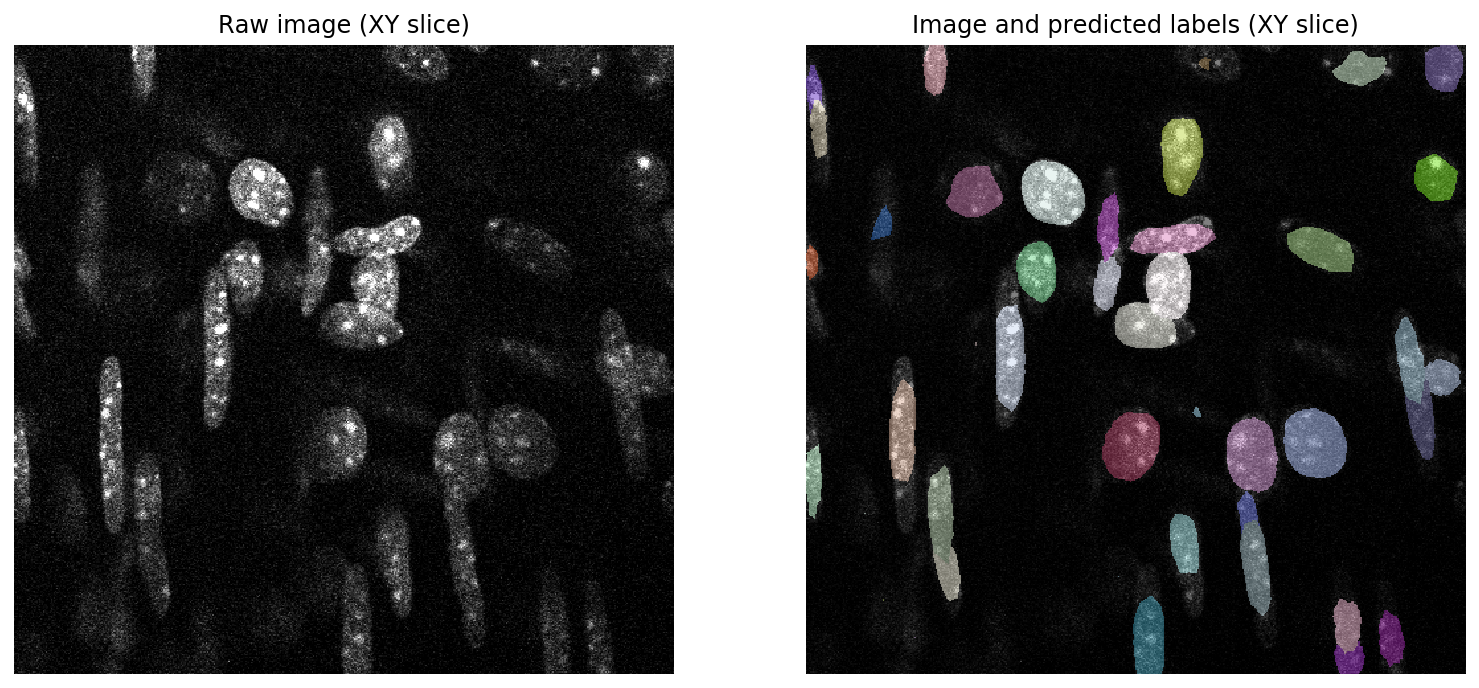

In [35]:
plt.figure(figsize=(13,10))
z = max(0, img.shape[0] // 2 - 5)
plt.subplot(121)
plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
plt.title('Raw image (XY slice)')
plt.axis('off')
plt.subplot(122)
plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
plt.imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
plt.title('Image and predicted labels (XY slice)')
plt.axis('off');

## Save predictions

Uncomment the lines in the following cell if you want to save the example image and the predicted label image to disk.

In [23]:
# save_tiff_imagej_compatible('example_image.tif', img, axes='ZYX')
# save_tiff_imagej_compatible('example_labels.tif', labels, axes='ZYX')

# Example results

In [49]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img,n_tiles=(20,20,2))

    plt.figure(figsize=(13,8))
    z = img.shape[0] // 2
    y = img.shape[1] // 2
    img_show = img if img.ndim==3 else img[...,:3]    
    plt.subplot(221); plt.imshow(img_show[z],   cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XY slice')
    plt.subplot(222); plt.imshow(img_show[:,y], cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XZ slice')
    plt.subplot(223); plt.imshow(img_show[z],   cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XY slice')
    plt.imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
    plt.subplot(224); plt.imshow(img_show[:,y], cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XZ slice')
    plt.imshow(labels[:,y], cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()
    save_tiff_imagej_compatible('example_image_zone1.tif', img, axes='ZYX')
    save_tiff_imagej_compatible('example_labels_zone1.tif', labels, axes='ZYX')

 10%|████████                                                                         | 20/200 [00:17<02:33,  1.17it/s]


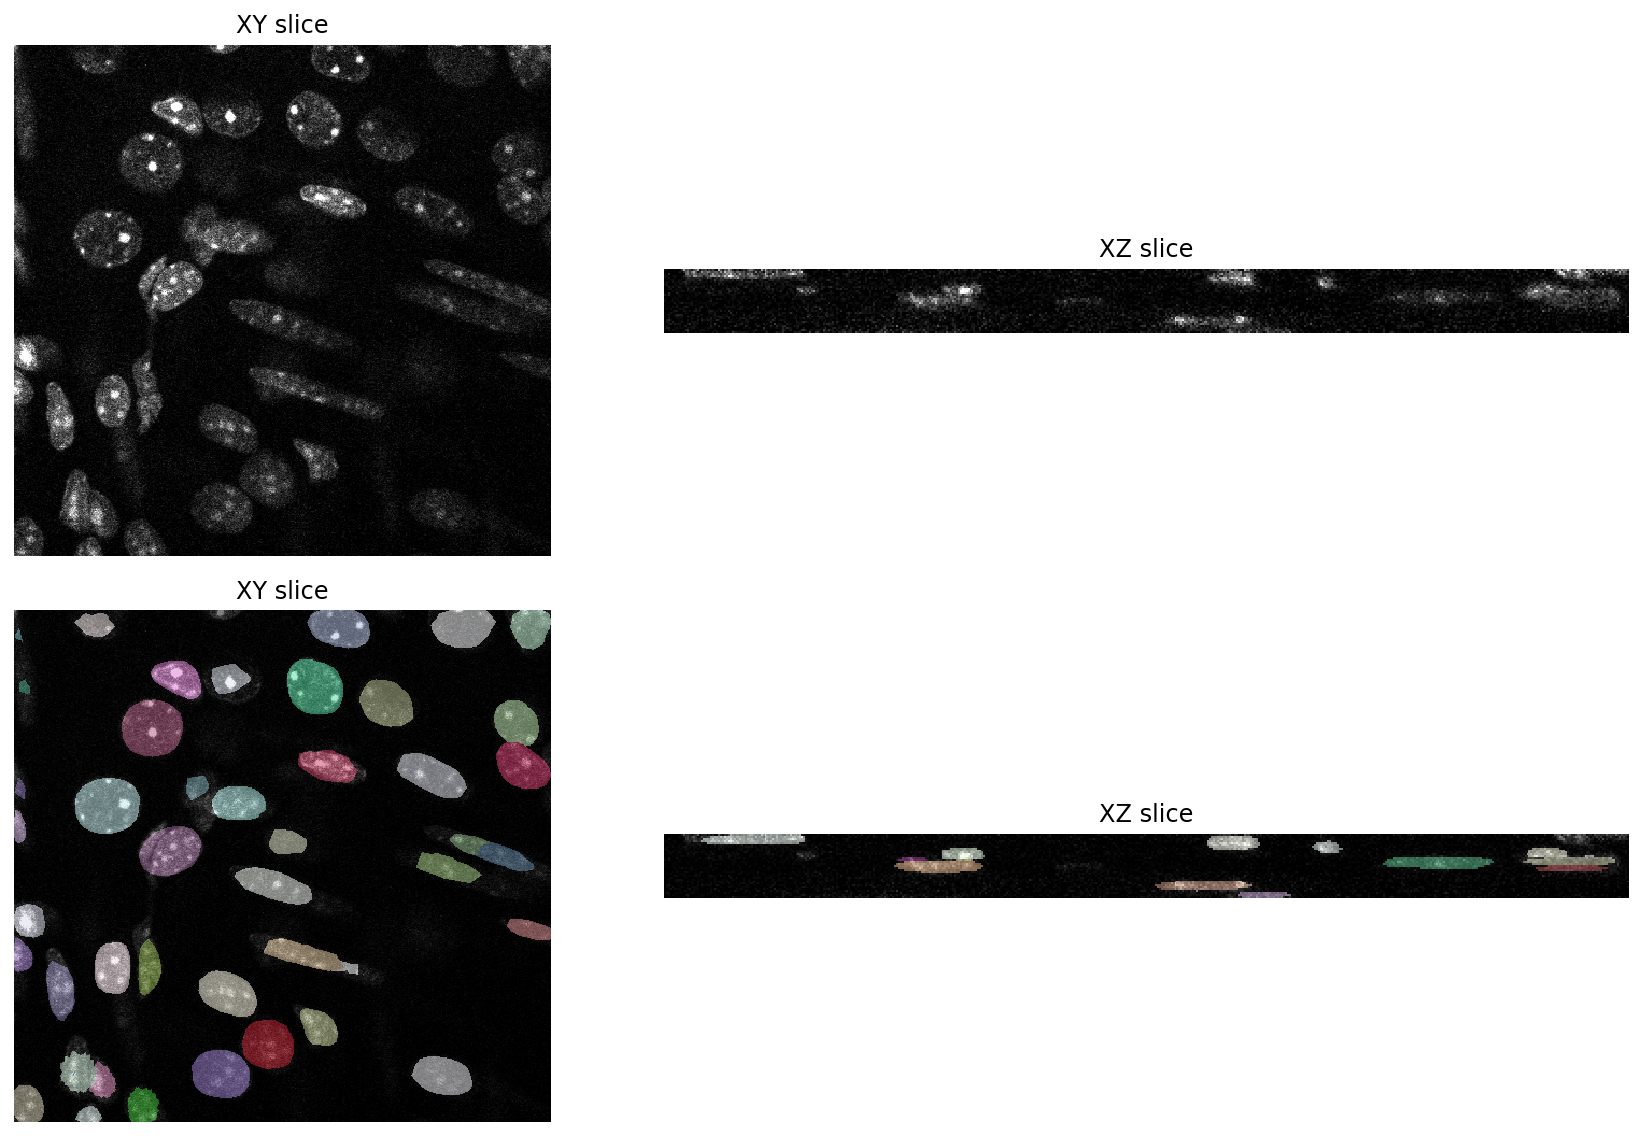

In [40]:
example(model, 0)

In [26]:
example(model, 1)

ResourceExhaustedError:  OOM when allocating tensor with shape[1,31,1024,1024,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_1/conv3d_15/Conv3D (defined at C:\Users\paul-gilloteaux-p\anaconda3\lib\site-packages\stardist\models\base.py:316) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_1979]

Function call stack:
predict_function


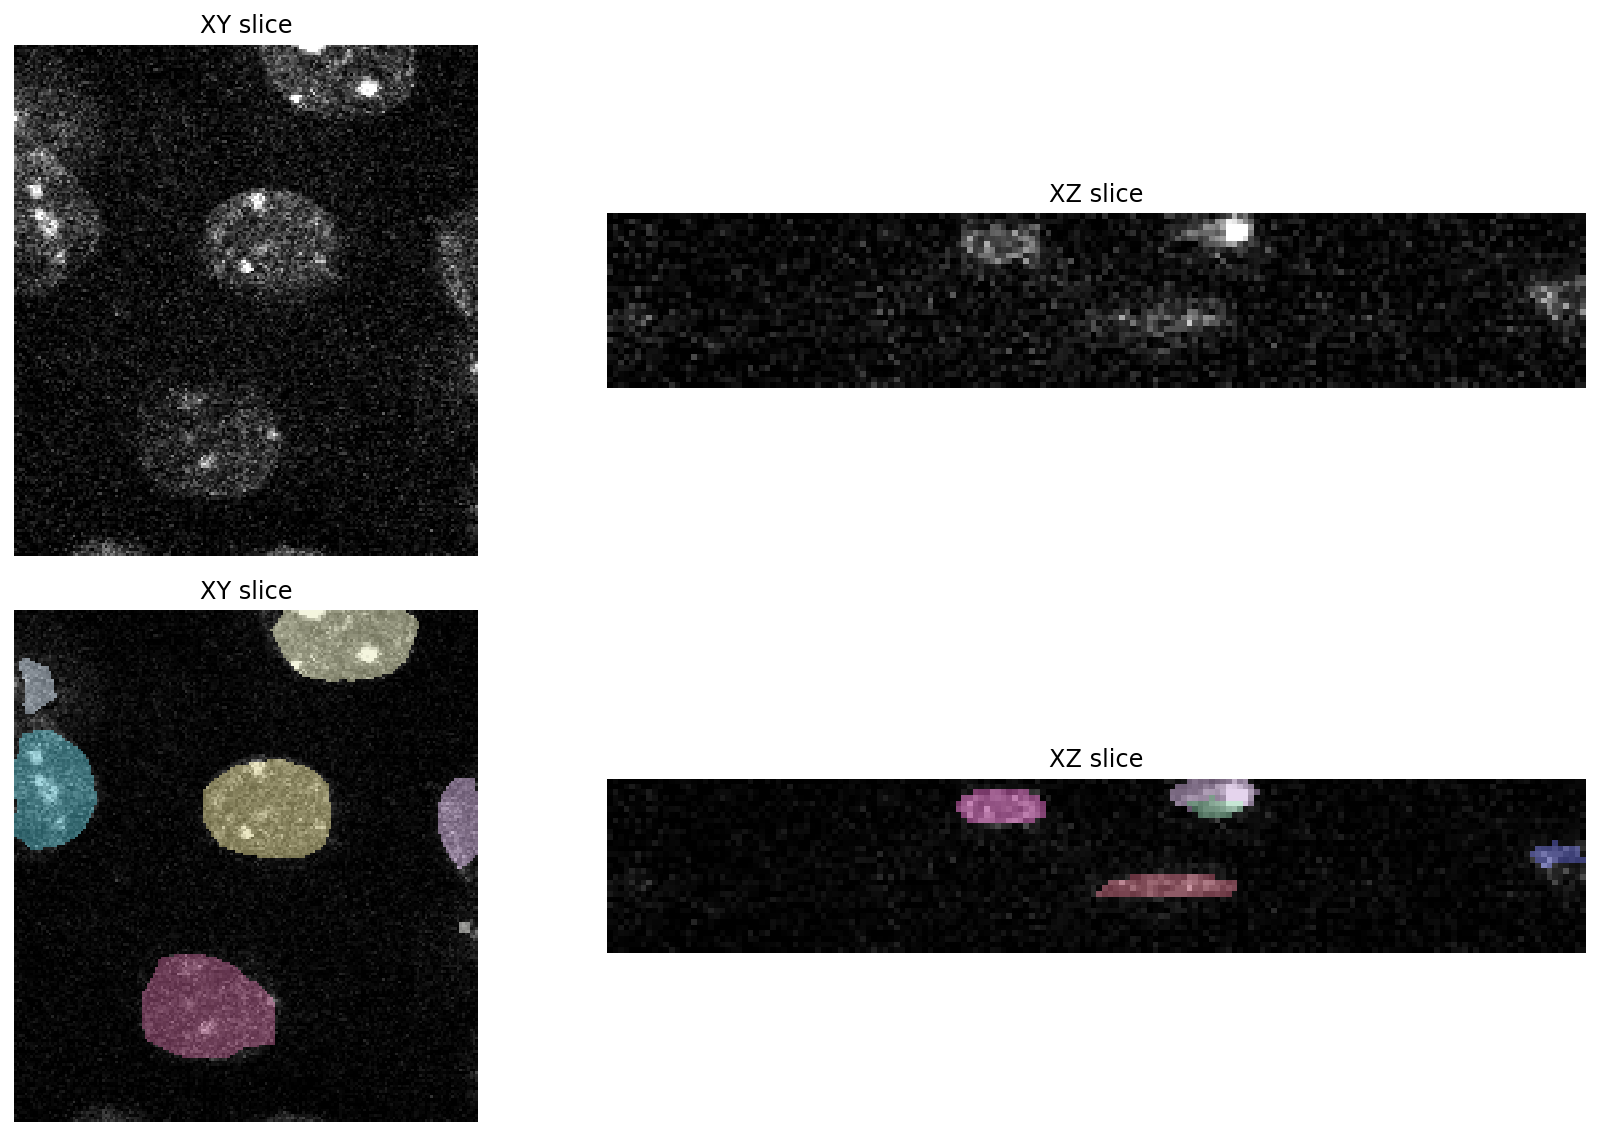

In [27]:
example(model, 2)

  5%|████                                                                             | 40/800 [01:17<24:34,  1.94s/it]


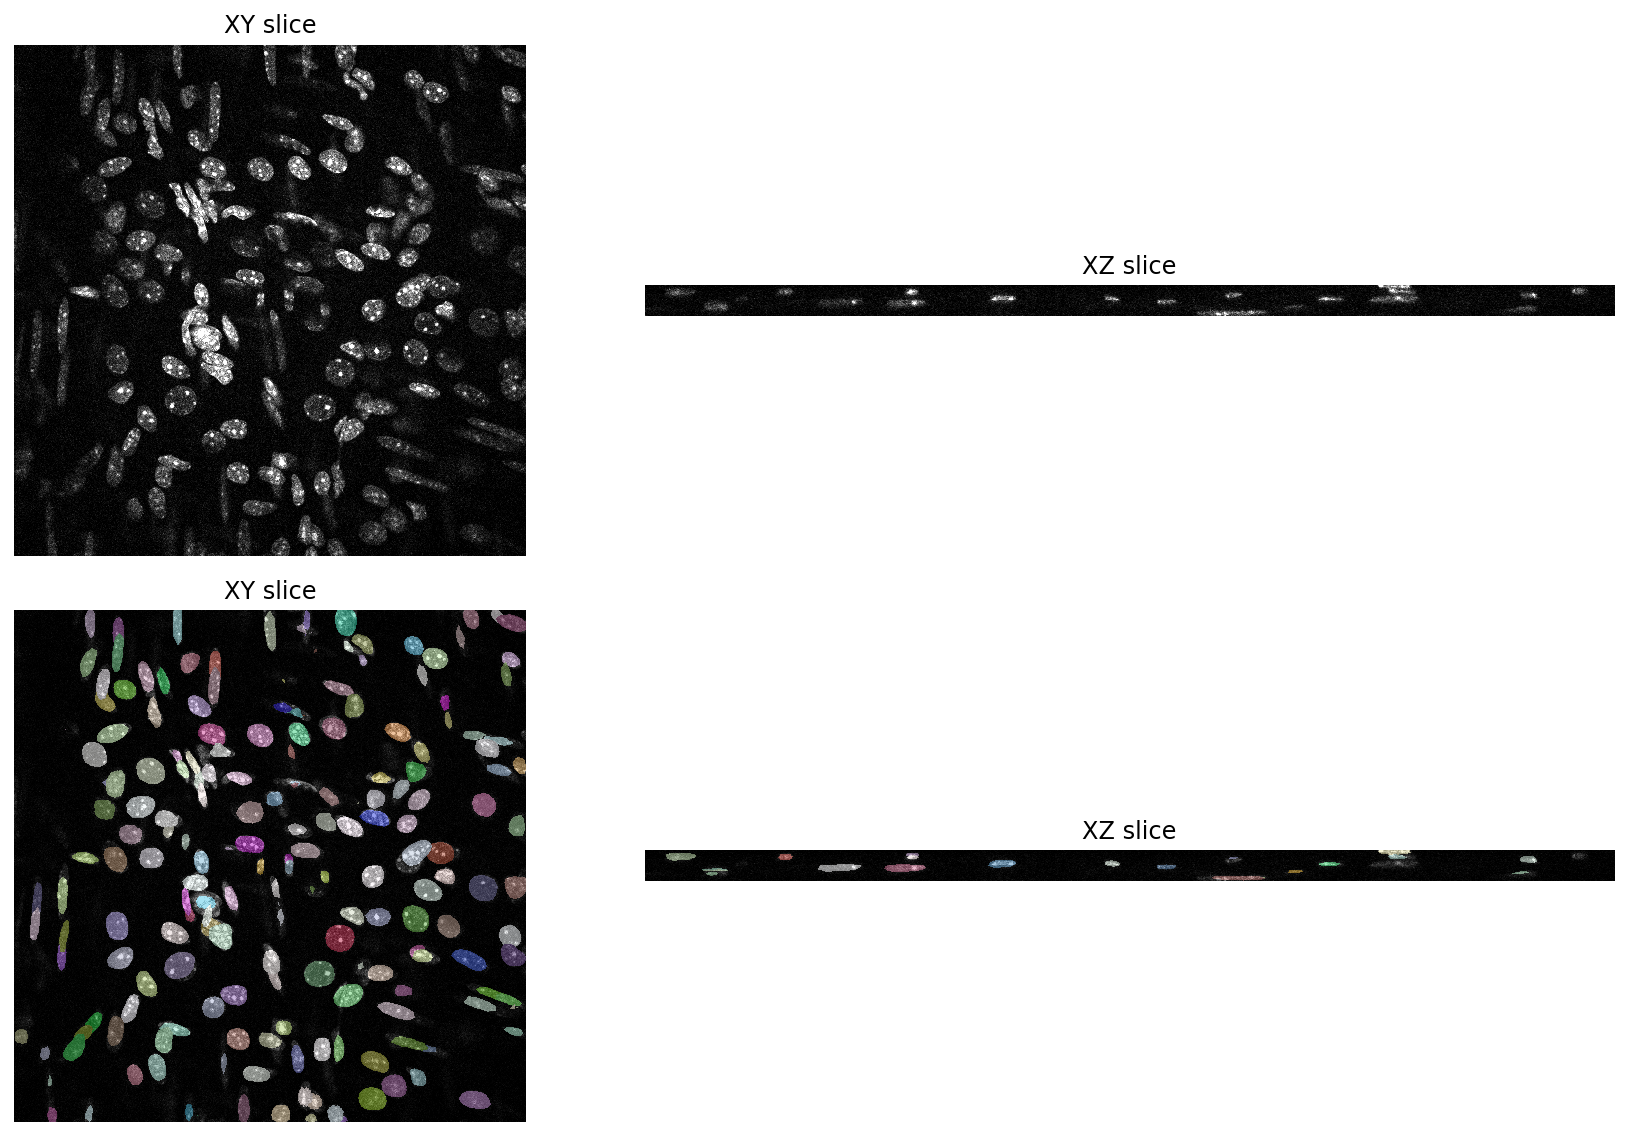

In [50]:
example(model, 1)